# Dimensionality Reduction with Scikit-learn

<a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons Licence" style="width=50" src="https://licensebuttons.net/l/by-nc-sa/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

**Authors**: Dr Matteo Degiacomi (matteo.t.degiacomi@durham.ac.uk) and Dr Antonia Mey (antonia.mey@ed.ac.uk)

Content is partially adapted from the [Software Carpentries Machine learning lesson](https://carpentries-incubator.github.io/machine-learning-novice-sklearn/index.html)

**Questions:**
- How can we perform unsupervised learning with dimensionality reduction?

**Learning Outcomes:**
- Recall that most data is inherently multidimensional
- Understand that reducing the number of dimensions can simplify modelling and allow classifications to be performed.
- Recall that PCA is a popular technique for dimensionality reduction.
- Recall that t-SNE is another technique for dimensionality reduction.
- Apply PCA and t-SNE with Scikit Learn to an example dataset.
- Evaluate the relative peformance of PCA and t-SNE.

**Jupyter cheat sheet**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;

## Dimensionality Reduction

Dimensionality reduction is the process of using a subset of the coordinates, which may be transformed, of the dataset to capture the variation in features of the data set. It can be a helpful pre-processing step before doing other operations on the data, such as classification, regression or visualization.

## The MNIST Dataset

The MNIST dataset consists of a 60,000 examples of hand written numbers and 10,000 test set examples. The digits have all been resized to the same size and centered within this fixed image size. One way of accessing the data is from [here](http://yann.lecun.com/exdb/mnist/) or we can use built in function with scikit-learn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import datasets
from sklearn import manifold

digits = datasets.load_digits()

# Examine the dataset
print(digits.data)
print(digits.target)

X = digits.data
y = digits.target

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[0 1 2 ... 8 9 8]


A short helper function to plot an example from the dataset:

In [2]:
import matplotlib.pyplot as plt


def plot_digits(X):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((8, 8)), cmap="Greys")
        ax.axis("off")

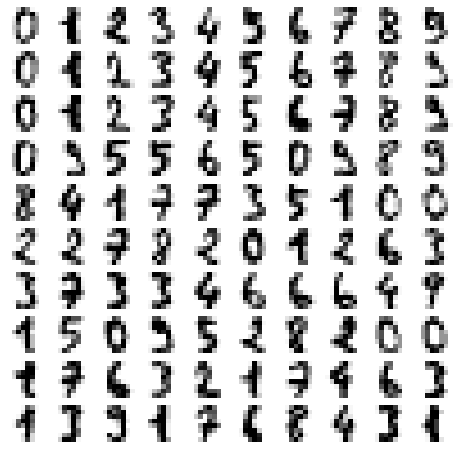

In [3]:
plot_digits(X)

## What is a feature?
A feature is a single data point in a feature vector on which you want to do an operation. For the MNIST dataset each pixels value is a feature. What you see above is a 8x8 representation of the image with each point in the 8x8 pixel image containing a certain value for the pixel. For us even looking at the rather pixelated images of the numbers we can recognise what each number is. 

<div class="alert alert-success">
<b>Task 1: Other features:</b> Can you think of examples of features that you would find in molecular simulations?  </div>

<details>
<summary> <mark> Solution: </mark> </summary>

Examples are:
- C-alpha positions
- Heavy atom positions
- angles
- dihedrals
- RMSD
- ...

</details>

## Dimensionality reduction
There are multiple reasons why you might want to do a dimensionality reduction. 
- You have too many features and clustering in high dimensions can be difficult. 
- You might want to know what are the dominant features in your system.
- You want a way to visualise your high dimensional data. 

We will look at Principle component analysis and t-tested stocastic neighbour embedding as two methods to allow you to reduce the dimensionality of your data, but also gain insights into your data. 

## Principle Component Analysis (PCA)
PCA is an orthogonal linear transformation that transforms high dimensional data (or feature vectors) into a new coordinate system. In this coordinate system the first coordinate corresponds to the scalar projection of a linear combination of some data such that this coordinate has the largest variance. The second largest variance in the data can be found in the second coordinate and so on. 

Let's look at a toy system to see how PCA works

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

We are defining a noisy linear model

In [5]:
# return noisy linear model
def f(x, a, b, sigma):
    return a*x + b + np.random.normal(0, sigma, len(x))

In [6]:
def muller_potential(x, y):
    """Muller potential
    
    Parameters
    ----------
    x : {float, np.ndarray}
        X coordinate. Can be either a single number or an array. If you supply
        an array, x and y need to be the same shape.
    y : {float, np.ndarray}
        Y coordinate. Can be either a single number or an array. If you supply
        an array, x and y need to be the same shape.
    Returns
    -------
    potential : {float, np.ndarray}
        Potential energy. Will be the same shape as the inputs, x and y.
    
    Reference
    ---------
    Code adapted from https://cims.nyu.edu/~eve2/ztsMueller.m
    """
    
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    
    value = 0
    for j in range(0, 4):
        value += AA[j] * np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
    return value

In [7]:
x = np.linspace(-1.5,1,200)
y = np.linspace(-0.4,1.8,200)

In [8]:
X, Y = np.meshgrid(x, y)

In [9]:
potential = muller_potential(X,Y)

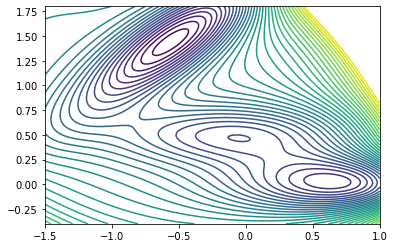

In [10]:
levels = np.linspace(np.min(potential),np.max(potential),50)
plt.contour(X, Y, potential.clip(max=200), 40);

In [11]:
Z = 0
for i in range(len(potential)):
    for j in range(len(potential[i])):
        Z+=np.exp(-1/100*potential[i][j])

In [12]:
P = np.zeros((200,200))

In [13]:
for i in range(len(P)):
    for j in range(len(P[i])):
        P[i][j] = np.exp(-1/100*potential[i][j])/Z

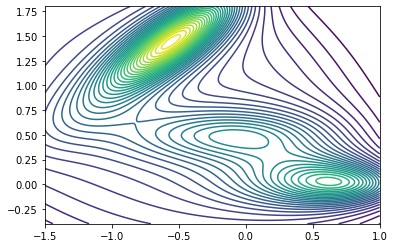

In [14]:
plt.contour(X, Y, P, 40);

In [20]:
flat = P.flatten()

# Then, sample an index from the 1D array with the
# probability distribution from the original array
sample_index = np.random.choice(a=flat.size, p=flat, size=10)

In [21]:
adjusted_index = np.unravel_index(sample_index, P.shape)

In [25]:
arr = np.array(zip(*adjusted_index))

In [33]:
arr = np.array(adjusted_index)

In [39]:
np.shape(arr.T)

(10, 2)

In [41]:
np.shape(potential[arr.T])

(10, 2, 200)

In [ ]:
Now let's generate some samples

# Create a flat copy of the array
flat = P.flatten()

# Then, sample an index from the 1D array with the
# probability distribution from the original array
sample_index = np.random.choice(a=flat.size, p=flat, size=1000)

# Take this index and adjust it so it matches the original array
adjusted_index = np.unravel_index(sample_index, P.shape)
np.array(zip(*adjusted_index))
print(adjusted_index)

In [116]:
np.shape(adjusted_index)

(2, 1000)

Let's generate the data and plot it:

In [27]:
x = np.arange(100)
y = f(x, 1, 10, 25)
data = np.array([x, y]).T

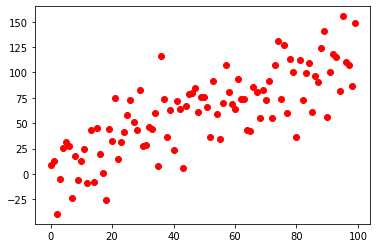

In [28]:
plt.scatter(x, y, c="red")

PCA can tell us in which features (here the x coordinate is one feature and the y coordinate is the second feature) or rather their linear combination carries the most variance. Below we can do a PCA with going from 2 dimension down to one dimension. 

In [29]:
pca = PCA(n_components=1)
pca.fit(data)

print("eigenvectors: ", pca.components_)
print("eigenvalues: ", pca.explained_variance_)

# print(f'eigenvectors length: {np.linalg.norm(pca.components_[0])}, {np.linalg.norm(pca.components_[1])}')
# print(f'eigenvectors angle: {np.rad2deg(np.arccos(np.dot(pca.components_[0], pca.components_[1])))}')

eigenvectors:  [[-0.55298978 -0.83318803]]
eigenvalues:  [2217.21786524]


In [33]:
pca.components_

array([[-0.55298978, -0.83318803]])

In [ ]:
scaling = 50
e1_x = pca.components_[0, 0]*pca.explained_variance_[0]
e1_y = pca.components_[0, 1]*pca.explained_variance_[0]
e2_x = pca.components_[1, 0]*pca.explained_variance_[1]
e2_y = pca.components_[1, 1]*pca.explained_variance_[1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y, c="red")
ax.arrow(np.mean(x), np.mean(y), e1_x/pca.explained_variance_[0]*scaling, e1_y/pca.explained_variance_[0]*scaling, head_width=5, head_length=5, fc='k', ec='k')
ax.arrow(np.mean(x), np.mean(y), e2_x/pca.explained_variance_[0]*scaling, e2_y/pca.explained_variance_[0]*scaling, head_width=5, head_length=5, fc='k', ec='k')

ax.set_xlim(-25, 150)
ax.set_ylim(-25, 150)

## t-Distributed Stochastic Neighbor Embedding (t-SNE) 
t-SNE is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. It gives each datapoint a poisition in a two or three dimensional map. It is classed as a non-linear dimensionality reduction technique and models high-dimensional data that a are close in space to spatially close two or three-deminsional points. 

In [ ]:
data, cluster_id = skl_datasets.make_blobs(n_samples=400, cluster_std=0.75, centers=4, random_state=1)

Now that we have some data we can go ahead and try to identify the clusters using K-means. First, we need to initialise the KMeans module and tell it how many clusters to look for. Next, we supply it some data via the fit function, in much the same we did with the regression functions earlier on. Finally, we run the predict function to find the clusters.

In [ ]:
Kmean = skl_cluster.KMeans(n_clusters=4)
Kmean.fit(data)
clusters = Kmean.predict(data)

The data can now be plotted to show all the points we randomly generated. To make it clearer which cluster points have been classified to we can set the colours (the c parameter) to use the clusters list that was returned by the predict function. The Kmeans algorithm also lets us know where it identified the centre of each cluster as. These are stored as a list called `cluster_centers_` inside the `Kmean` object. Let’s go ahead and plot the points from the clusters, colouring them by the output from the K-means algorithm, and also plot the centres of each cluster as a red X.

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(data[:, 0], data[:, 1], s=5, linewidth=0, c=clusters)
for cluster_x, cluster_y in Kmean.cluster_centers_:
    plt.scatter(cluster_x, cluster_y, s=100, c='r', marker='x')
plt.show()

In [ ]:
import sklearn.cluster as skl_cluster
import sklearn.datasets as skl_datasets
import matplotlib.pyplot as plt

data, cluster_id = skl_datasets.make_blobs(n_samples=400, cluster_std=0.75, centers=4, random_state=1)

Kmean = skl_cluster.KMeans(n_clusters=4)
Kmean.fit(data)
clusters = Kmean.predict(data)

plt.scatter(data[:, 0], data[:, 1], s=5, linewidth=0, c=clusters)
for cluster_x, cluster_y in Kmean.cluster_centers_:
    plt.scatter(cluster_x, cluster_y, s=100, c='r', marker='x')
plt.show()

<div class="alert alert-info">
<b>Working in multiple dimensions:</b>
Although this example shows two dimensions the kmeans algorithm can work in more than two, it just becomes very difficult to show this visually once we get beyond 3 dimensions. Its very common in machine learning to be working with multiple variables and so our classifiers are working in multi-dimensional spaces.
</div>


In [ ]:
# ================================
# First task secion
# ================================

<div class="alert alert-success">
<b>Task 1: Discuss: </b> </div>
    What are the limitations and advantages of K-Means?


<details>
<summary> <mark> Solution: Suggested limitations and advantages</mark> </summary>

Limitations:
- Requires number of clusters to be known in advance
- Struggles when clusters have irregular shapes
- Will always produce an answer finding the required number of clusters even if the data isn’t clustered (or clustered in that many clusters).
- Requires linear cluster boundaries

Advantages:
- Simple algorithm, fast to compute. A good choice as the first thing to try when attempting to cluster data.
- Suitable for large datasets due to its low memory and computing requirements.

</details>

<div class="alert alert-success">
<b>Task 2: K-means with overlapping clusters </b> </div>
    Adjust the program above to increase the standard deviation of the blobs (the cluster_std parameter to make_blobs) and increase the number of samples (n_samples) to 4000. You should start to see the clusters overlapping. Do the clusters that are identified make sense? Is there any strange behaviour from this?


<details>
<summary> <mark> Solution: Try it yourself</mark> </summary>

```Python
   a = b 
```

</details>

<div class="alert alert-success">
<b>Task 3: How many clusters should we look for? </b> </div>
Adjust the program above to increase the standard deviation of the blobs (the cluster_std parameter to make_blobs) and increase the number of samples (n_samples) to 4000. You should start to see the clusters overlapping. Do the clusters that are identified make sense? Is there any strange behaviour from this?



<details>
<summary> <mark> Solution: Try it yourself</mark> </summary>

```Python
   a = b 
```

</details>

In [ ]:
## intro to DB scan

In [ ]:
## Use DB scan for ring dataset?

In [ ]:
## Spectral clustering?

In [ ]:
## Introduce Alanine dipeptide dataset

In [ ]:
## What happens when we cluster ADP with k-means, DB scan or spectral clustering?

<div class="alert alert-info">
<b>Key points:</b></div>   

- Clustering is a form of unsupervised learning   
- Unsupervised learning algorithms don’t need training   
- Kmeans is a popular clustering algorithm.   
- Kmeans struggles where one cluster exists within another, such as concentric circles.   
- Spectral clustering is another technique which can overcome some of the limitations of Kmeans.    
- Spectral clustering is much slower than Kmeans.    
- As well as providing machine learning algorithms scikit learn also has functions to make example data   


## Next Notebook

[Classification](ML_RF_03.ipynb)